In [1]:
from lgnpy.CEandSC.lgn_statistics import lgn_statistics, interp1d, regress
# conv2padded, filter_lgn, create_hist, local_cov
from result_manager.result_manager import ResultManager
from lgnpy.run_LGNstatistics import loadmat
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import zscore
import os
from sklearn.linear_model import LinearRegression
import multiprocessing
import warnings
import tqdm
from scipy.optimize import minimize

In [2]:
erp = loadmat('/home/niklas/projects/eeg_jneurosc13/ERPs_singlesubjects14_singletrials_behexcluded.mat')
sensors = erp['sensors']
data = erp['Y']

# Setup

In [3]:
# # viewing_dist=1
# # dot_pitch=0.00035
# # fov_beta=1.5
# # fov_gamma=5

# # # if im.shape[-1] == 2:
# # #     IMTYPE = 1  # Gray
# # # elif im.shape[-1] == 3:
# # IMTYPE = 2  # Color

# # # imsize = im.shape[:2]
# # imsize = (480, 640)

# # #######################################################
# # # Set parameters for field of view
# # #######################################################

# def setup(imsize, viewing_dist=1, dot_pitch=0.00035, fov_beta=1.5, fov_gamma=5):

#     fovx = round(imsize[1]/2)          # x-pixel loc. of fovea center
#     fovy = round(imsize[0]/2)          # y-pixel loc. of fovea center
#     # ex and ey are the x- and y- offsets of each pixel compared to
#     # the point of focus (fovx,fovy) in pixels.
#     ex, ey = np.meshgrid(np.arange(start=-fovx+1, stop=imsize[1]-fovx+1),
#                         np.arange(start=-fovy+1, stop=imsize[0]-fovy+1))
#     # eradius is the radial distance between each point and the point
#     # of gaze.  This is in meters.
#     eradius = dot_pitch * np.sqrt(ex**2+ey**2)
#     #del ex, ey
#     # calculate ec, the eccentricity from the foveal center, for each
#     # point in the image.  ec is in degrees.
#     ec = 180*np.arctan(eradius / viewing_dist)/np.pi
#     # select the pixels that fall within the input visual field of view
#     imfovbeta = (ec < fov_beta)
#     imfovgamma = (ec < fov_gamma)

#     return imfovbeta, imfovgamma

In [4]:
threshold_lgn = loadmat('/home/niklas/projects/lgnpy/ThresholdLGN.mat')
threshold_lgn = threshold_lgn['ThresholdLGN']

Could not load mat file with mat73 - trying to load with scipy.io.loadmat!


# Get CE/SC

In [5]:
root = '/home/niklas/projects/eeg_jneurosc13/allstim/'
image_names = [f for f in os.listdir(root) if os.path.join(root, f).endswith('jpg')]

In [6]:
def iterate(args):
    image_name, image_index, config = args
    im = Image.open(os.path.join('/home/niklas/projects/eeg_jneurosc13/allstim/', image_name))
    im = np.array(im)

    (ce, sc, beta, gamma) = lgn_statistics(im=im, file_name=image_name, config=config, threshold_lgn=threshold_lgn)

    return ce, sc, image_index

In [7]:
def get_sc_ce(image_names, threshold_lgn, config):
    ces = np.zeros((len(image_names), 3, 1, 2))
    scs = np.zeros((len(image_names), 3, 1, 2))


    with multiprocessing.Pool() as pool:
        results = list(tqdm.tqdm(pool.imap(iterate, [(image_name, index, config) for index, image_name in enumerate(image_names)]), total=len(image_names)))
    
    for ce, sc, index in results:
        # Make sure that this is in the same order as the ERP data!
        filename = image_names[index]
        index = int(filename.split('.')[0].split('_')[1]) - 1
        ces[index, :,:,:] = ce
        scs[index, :,:,:] = sc

    return ces, scs

## Create Design Matrix

In [8]:
def regression(ces, scs):
    average_colors = True

    if average_colors:
        ce_avg = zscore(np.mean(ces[:,:,0,0], axis=-1))
        sc_avg = zscore(np.mean(scs[:,:,0,0], axis=-1))
    else:
        ce_avg = zscore(ces[:,:,0,0], axis=0)
        sc_avg = zscore(scs[:,:,0,0], axis=0)

    if len(ce_avg.shape) > 1:
        c = np.ones((ce_avg.shape[0], 1)) #* np.mean(ce_avg)
        zeros = np.zeros(ce_avg.shape)
        rep1 = np.hstack((c, ce_avg, zeros, sc_avg, zeros))
        rep2 = np.hstack((c, zeros, ce_avg, zeros, sc_avg))
        design_matrix = np.vstack((rep1, rep2))
    else:
        c = np.ones((ce_avg.shape[0])) #* np.mean(ce_avg)
        zeros = np.zeros(ce_avg.shape)
        rep1 = np.vstack((c, ce_avg, zeros, sc_avg, zeros))
        rep2 = np.vstack((c, zeros, ce_avg, zeros, sc_avg))
        design_matrix = np.hstack((rep1, rep2)).T

    r2_sensors = {}
    beta_sensors = {}
    
    for sensor_index, sensor in [(43, 'Oz')]:
        r2_subjects = {}
        beta_subjects = {}
        for subject in range(14):
            r2s = []
            betas = []
            for time_index in range(154):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)
                    # y = np.repeat(np.nanmean(np.vstack((data[subject,time_index,sensor_index,:1600] ,data[subject,time_index,sensor_index,1600:])), axis=0), repeats=2)
                    y = data[subject,time_index,sensor_index,:]
                # mask = np.isnan(y)
                # x = design_matrix[~mask]
                # y = zscore(y[~mask])
                # if x.shape[0] == 0 or y.shape[0] == 0:
                #     r2s.append(-1)
                #     continue

                # lin_reg = LinearRegression().fit(x, y)
                # r2 = lin_reg.score(x,y)
                # beta = lin_reg.coef_
                r2, beta = regress(y, design_matrix=design_matrix)
                r2s.append(r2)
                betas.append(beta)

            r2_subjects[subject] = r2s
            beta_subjects[subject] = betas

        # res.append(r2_subjects.values())

    r2_sensors[sensor] = r2_subjects
    beta_sensors[sensor] = beta_subjects
    
    return (r2_sensors, beta_sensors)

In [9]:
# This needs to take any input variable, not sure how to do this. Easiest and most flexible would be to have any loose variable defined in a dictionary
def comb(image_names, threshold_lgn, config):
    ces, scs = get_sc_ce(image_names, threshold_lgn=threshold_lgn, config=config)
    return regression(ces, scs)

In [ ]:
configs = [{
    'viewing_dist': 1
},
{
    'viewing_dist': 5
}]

res = []

# for viewing_dist in [0.5, 0.8, 1.0, 1.5]:
for config in configs:
    res.append(comb(image_names=image_names, threshold_lgn=threshold_lgn, config=config))

In [ ]:
res[0][0]["Oz"]

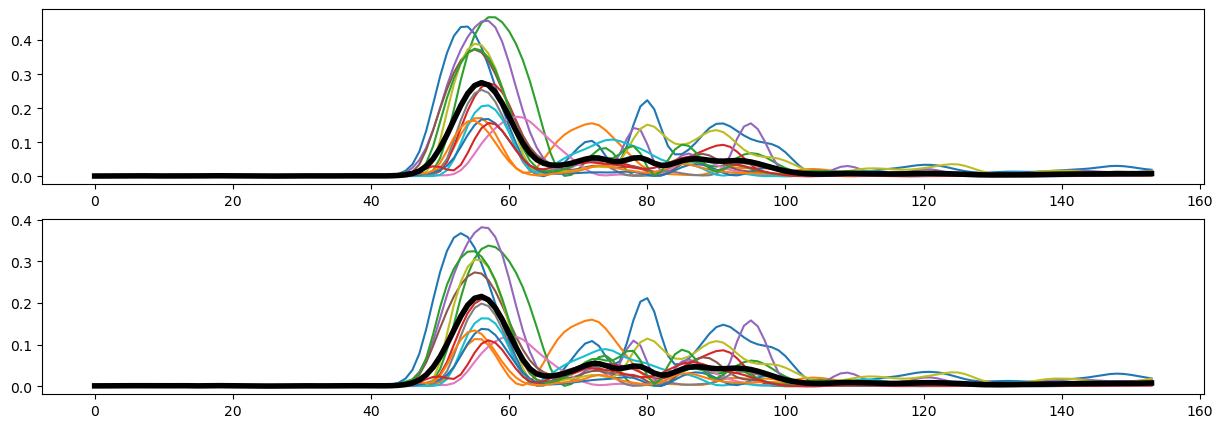

In [12]:
fig, ax = plt.subplots(2,1, figsize=(15,5))
for sub in range(14):
    ax[0].plot(res[0][0]['Oz'][sub])

ax[0].plot(np.mean(np.array([x for _, x in res[0][0]['Oz'].items()]), axis=0), 'k', linewidth=4.0)
for sub in range(14):
    ax[1].plot(res[1][0]['Oz'][sub])

ax[1].plot(np.mean(np.array([x for _, x in res[1][0]['Oz'].items()]), axis=0), 'k', linewidth=4.0)

In [23]:
result_manager = ResultManager(root='/home/niklas/projects/lgnpy/lgnpy/fitter/results')
loaded_res = result_manager.load_result(filename='full_fitting_results.pkl')

In [ ]:
loaded_res[0][0]['TP8'][13]

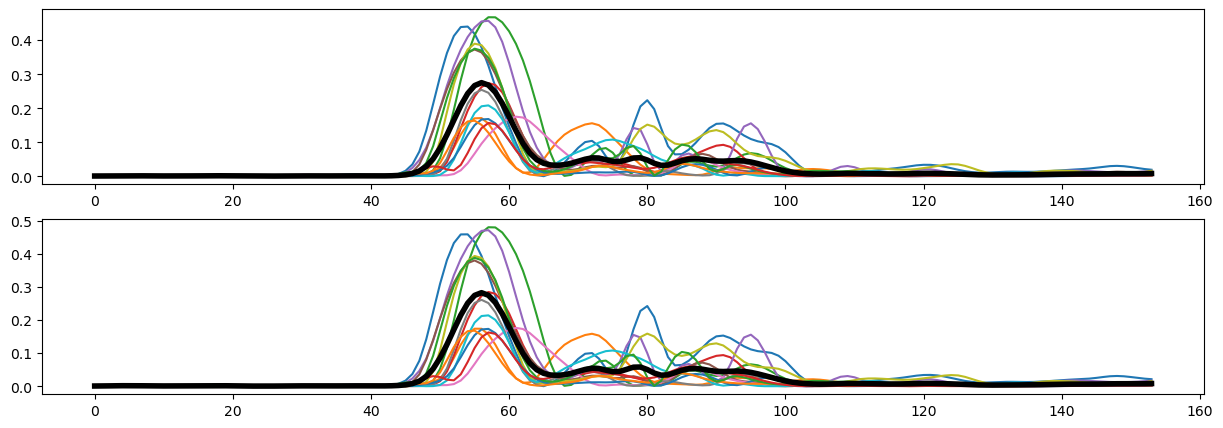

In [26]:
fig, ax = plt.subplots(2,1, figsize=(15,5))
for sub in range(14):
    ax[0].plot(loaded_res[0][0]['Oz'][sub])

ax[0].plot(np.mean(np.array([x for _, x in loaded_res[0][0]['Oz'].items()]), axis=0), 'k', linewidth=4.0)
for sub in range(14):
    ax[1].plot(loaded_res[1][0]['Oz'][sub])

ax[1].plot(np.mean(np.array([x for _, x in loaded_res[1][0]['Oz'].items()]), axis=0), 'k', linewidth=4.0)